In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc
import re

In [2]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

## Helper functions

In [3]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [4]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [5]:
def read_adata_backed_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [6]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [7]:
def obs_with_umap(adata):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    
    umap_mat = adata.obsm['X_umap']
    umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
    obs['umap_1'] = umap_df['umap_1']
    obs['umap_2'] = umap_df['umap_2']
    
    return obs

In [8]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Identify files for use in HISE

In [9]:
search_ids = {
    'b':       'aluminum-thorium-neon',
    't_cd4':   'mercury-polonium-zinc',
    't_cd8':   'fermium-chromium-gallium',
    't_other': 'magnesium-potassium-zinc',
    'myeloid': 'neptunium-cadmium-erbium',
    'nk':      'livermorium-copper-curium',
    'other':   'thorium-zirconium-nobelium'
}

Retrieve files stored in our HISE project store

In [10]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [11]:
search_string = '|'.join(search_ids.values())

search_df = ps_df[ps_df['name'].str.contains(search_string)]
search_df = search_df[search_df['name'].str.contains('.h5ad')]

search_df = search_df.sort_values('name')

search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [12]:
print(len(search_df['AIFI_L3'].tolist()))
search_df['AIFI_L3'].head().tolist()

71


['Activated memory B cell',
 'CD27- effector B cell',
 'CD27+ effector B cell',
 'CD95 memory B cell',
 'Core memory B cell']

## Read a subset of cells to identify HVGs

For use in PCA on the whole dataset, we'll first read in a small set of each cell type and generate HVGs.

Then, we'll read in the data for just those HVGs across the entire dataset to ensure we don't run out of available memory.

In [12]:
n_per_type = 1000

In [13]:
sampled_file = 'output/diha_sampled_1000_per_AIFI_L3_type_{d}.h5ad'.format(d = date.today())

In [ ]:
if os.path.isfile(sampled_file):
    sampled_adata = sc.read_h5ad(sampled_file)
else:
    sampled_adata_list = []
    for uuid in search_df['id']:
        adata = read_adata_uuid(uuid)
        if adata.shape[0] > n_per_type:
            sc.pp.subsample(adata, n_obs = n_per_type, random_state = 3030)
        sampled_adata_list.append(adata)
    
    sampled_adata = sc.concat(sampled_adata_list)
    
    del(sampled_adata_list)
    
    sampled_adata.write_h5ad(sampled_file)

In [14]:
sampled_adata

AnnData object with n_obs × n_vars = 70579 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'file.id', 'subject.cmv', 'subject.bmi', 'predicted_AIFI_L1', 'AIFI_L1_score', 'predicted_AIFI_L2', 'AIFI_L2_score', 'predicted_doublet', 'doublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_2', 'AIFI_L3', 'AIFI_L3_score', 'predicted_AIFI_L3', 'AIFI_L2', 'AIFI_L1'
    var: 'highly_variable', 'highly_v

## Find global HVGs

In [15]:
sc.pp.highly_variable_genes(sampled_adata, flavor = 'seurat_v3', n_top_genes = 500)

In [16]:
global_hvg = sampled_adata.var.highly_variable

In [17]:
sum(global_hvg)

500

## Find HVGs within L1 and L2 levels

In [18]:
l1_classes = sampled_adata.obs['AIFI_L1'].unique().tolist()

Skip platelets, which cause errors

In [19]:
l1_classes = set(l1_classes) - set(['Platelet'])
l1_classes = list(l1_classes)

In [20]:
l1_hvg = {}
for l1_class in l1_classes:
    print(l1_class)
    l1_adata = sampled_adata[sampled_adata.obs['AIFI_L1'] == l1_class]
    sc.pp.highly_variable_genes(l1_adata, flavor = 'seurat_v3', n_top_genes = 250)
    l1_hvg[l1_class] = l1_adata.var.highly_variable

Erythrocyte
Progenitor cell
B cell
NK cell
ILC
T cell
Monocyte
DC


In [21]:
l2_classes = sampled_adata.obs['AIFI_L2'].unique().tolist()

In [22]:
l2_classes = set(l2_classes) - set(['Platelet'])
l2_classes = list(l2_classes)

In [23]:
l2_hvg = {}
for l2_class in l2_classes:
    print(l2_class)
    l2_adata = sampled_adata[sampled_adata.obs['AIFI_L2'] == l2_class]
    sc.pp.highly_variable_genes(l2_adata, flavor = 'seurat_v3', n_top_genes = 250)
    l2_hvg[l2_class] = l2_adata.var.highly_variable

Transitional B cell
Memory B cell
Effector B cell
Progenitor cell
Intermediate monocyte
Memory CD4 T cell
Memory CD8 T cell
ILC
CD56bright NK cell
cDC1
MAIT
ASDC
Naive B cell
gdT
CD16 monocyte
Proliferating T cell
Erythrocyte
Naive CD8 T cell
CD8aa
Proliferating NK cell
Treg
Plasma cell
CD14 monocyte
pDC
cDC2
Naive CD4 T cell
DN T cell
CD56dim NK cell


## Combine HVGs

In [24]:
all_hvg = global_hvg
for hvg in l1_hvg.values():
    all_hvg = all_hvg + hvg

In [25]:
sum(all_hvg)

1279

In [26]:
for hvg in l2_hvg.values():
    all_hvg = all_hvg + hvg

In [27]:
sum(all_hvg)

2617

## Preview projection with our subsampled data

In [28]:
adata = sampled_adata

In [29]:
adata.var.highly_variable = all_hvg

In [30]:
print('Normalizing', end = "; ")
# Normalize and log transform
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

print('Scaling', end = "; ")
# Scale variable genes
sc.pp.scale(adata)

print('PCA', end = "; ")
# Run PCA
sc.tl.pca(adata, svd_solver = 'arpack')

print('Neighbors', end = "; ")
# Find nearest neighbors
sc.pp.neighbors(
    adata, 
    n_neighbors = 50,
    n_pcs = 30
)

print('UMAP', end = "; ")
# Run UMAP
sc.tl.umap(adata, min_dist = 0.05)

Normalizing; Scaling; PCA; Neighbors; UMAP; 

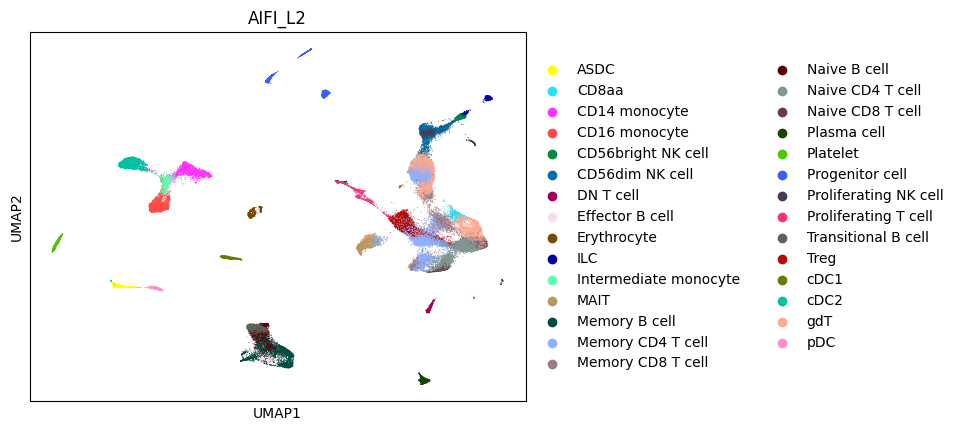

In [31]:
sc.pl.umap(adata, color = 'AIFI_L2')

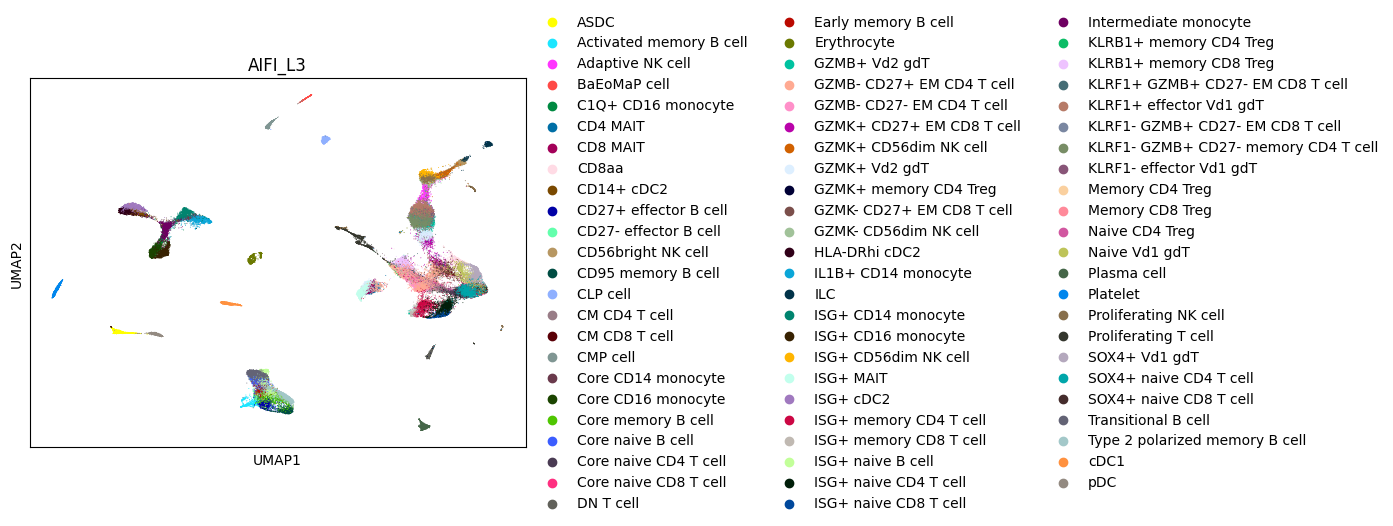

In [32]:
sc.pl.umap(adata, color = 'AIFI_L3')

Looks pretty good, given the distortion in cell type proportions that are introduced by equally sampling cell types.

## Load and normalize all cells and filter for HVGs

In [14]:
filtered_file = 'output/diha_all_cells_hvg_filtered_{d}.h5ad'.format(d = date.today())

In [33]:
if os.path.isfile(filtered_file):
    filtered_adata = sc.read_h5ad(filtered_file)
else:
    filtered_adata_list = []
    running_total = 0
    for uuid in search_df['id']:
        adata = read_adata_uuid(uuid)
        adata = adata.raw.to_adata()
        del(adata.obsm)
        del(adata.uns)
        
        ct = adata.obs['AIFI_L3'][0]
        print(ct, end = '; ')
        
        sc.pp.normalize_total(adata, target_sum = 1e4)
        sc.pp.log1p(adata)
        
        print('start: ' + str(adata.shape[1]), end = '; ')
        adata = adata[:,all_hvg].copy()
        print('end: ' + str(adata.shape[1]), end = '; ')

        n_cells = adata.shape[0]
        print('n: ' + str(n_cells), end = '; ')

        running_total = running_total + n_cells
        print('total: ' + str(running_total))
        
        filtered_adata_list.append(adata)
        
    filtered_adata = sc.concat(filtered_adata_list)
    del(filtered_adata_list)
    
    filtered_adata.write_h5ad(filtered_file)

In [34]:
filtered_adata.shape

(13795227, 2617)

## Perform scaling and PCA

In [35]:
%%time
sc.pp.scale(filtered_adata)

CPU times: user 3min 11s, sys: 2min 35s, total: 5min 46s
Wall time: 5min 47s


In [36]:
%%time
sc.tl.pca(filtered_adata, svd_solver = 'arpack')

CPU times: user 8h 49min 41s, sys: 38min 30s, total: 9h 28min 12s
Wall time: 12min 9s


In [46]:
pca_df = filtered_adata.obsm['X_pca']
pca_df = pd.DataFrame(pca_df)
pca_df.columns = ['PC' + str(x) for x in range(1,51)]
pca_df = pca_df.set_index(filtered_adata.obs['barcodes'], drop = True)

In [15]:
pca_csv_file = 'output/diha_all_cells_pcs_{d}.csv'.format(d = date.today())

In [ ]:
pca_df.to_csv(pca_csv_file)

In [16]:
pca_parquet_file = 'output/diha_all_cells_pcs_{d}.parquet'.format(d = date.today())

In [ ]:
pca_df.to_parquet(pca_parquet_file)

In [17]:
pca_h5ad_file = 'output/diha_all_cells_post-pca_{d}.h5ad'.format(d = date.today())

In [ ]:
filtered_adata.write_h5ad(pca_h5ad_file)

## Find NN and run UMAP

In [51]:
%%time
sc.pp.neighbors(
    filtered_adata, 
    n_neighbors = 50,
    n_pcs = 30
)

CPU times: user 6h 59min 59s, sys: 5h 18min 33s, total: 12h 18min 33s
Wall time: 1h 11min 54s


In [ ]:
%%time
sc.tl.umap(
    filtered_adata
)

In [60]:
umap_df = obs_with_umap(filtered_adata)

In [61]:
umap_df.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,log1p_total_counts_mito,pct_counts_mito,leiden_2,AIFI_L3,AIFI_L3_score,predicted_AIFI_L3,AIFI_L2,AIFI_L1,umap_1,umap_2
0,23a9db5401cd11ec9bd81eda61cbfa79,B078,effete_shimmery_vireo,23a9db5401cd11ec9bd81eda61cbfa79,B078-P2C2,AAGTATCGTTTCGCA,singlet,1530,323,15714,...,5.780744,6.719368,0,Activated memory B cell,1.0,Activated memory B cell,Memory B cell,B cell,-0.813825,-9.114863
1,7c0653f8d6af11eab3d05e71cfe5894e,B005,merciful_piscine_cockatiel,7c0653f8d6af11eab3d05e71cfe5894e,B005-P1C1,AAATCTCTCAGGCTC,singlet,1199,97,7006,...,4.584967,2.852102,0,Activated memory B cell,1.0,Activated memory B cell,Memory B cell,B cell,-1.685259,-7.382333
2,1e1f6b200f5e11ebb5dad23046770a87,B026,delusional_deadbeat_rottweiler,1e1f6b200f5e11ebb5dad23046770a87,B026-P1C1,CTCCTCTGCAATTAC,singlet,2360,146,23033,...,4.990433,1.882414,8,Activated memory B cell,1.0,Activated memory B cell,Memory B cell,B cell,-2.018401,-7.676921
3,cbbab8183ebe11eb9f6d666e6b6edd05,B039,salmonlike_derelict_cockatoo,cbbab8183ebe11eb9f6d666e6b6edd05,B039-P2C2,AGTAAGTTCAGCGTA,singlet,1352,210,12046,...,5.351858,5.477308,0,Activated memory B cell,1.0,Activated memory B cell,Memory B cell,B cell,-1.786906,-8.162902
4,cbbc79323ebe11eb9f6d666e6b6edd05,B039,hillocky_mettlesome_bighorn,cbbc79323ebe11eb9f6d666e6b6edd05,B039-P2C2,AGTAAGTTCAGCGTA,singlet,1105,91,8819,...,4.521789,3.452200,0,Activated memory B cell,1.0,Activated memory B cell,Memory B cell,B cell,-1.542180,-7.989615


In [18]:
umap_csv_file = 'output/diha_all_cells_umap_{d}.csv'.format(d = date.today())

In [ ]:
umap_df.to_csv(umap_csv_file)

In [19]:
umap_parquet_file = 'output/diha_all_cells_umap_{d}.parquet'.format(d = date.today())

In [ ]:
umap_df.to_parquet(umap_parquet_file)

In [31]:
umap_h5ad_file = 'output/diha_all_cells_umap_{d}.h5ad'.format(d = date.today())

In [ ]:
filtered_adata.write_h5ad(umap_h5ad_file)

## Upload Sample data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [21]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA All Cell UMAP {d}'.format(d = date.today())

In [22]:
search_id = element_id()
search_id

'neutron-plutonium-argon'

In [23]:
in_files = search_df['id'].tolist()
in_files

['1e8c6893-2294-41f8-97a7-f0855e2c7a24',
 '196ed0aa-dd8f-4d20-b890-43df425dbbb2',
 '1c1dc7a5-ce1c-43b7-9532-f857720f5125',
 'abee0c76-8900-4648-9fa9-e044d601e669',
 '8af856b5-1758-4623-9fe2-a9f27cf92b5c',
 '5db86bfd-b109-4d54-972b-4d02e9f6bdc2',
 'c1785810-e96f-43ab-9e0c-2328519c33f9',
 'b8581cf8-08c9-4126-89da-f125ec5154b9',
 'b5ec533a-1c4f-466e-9dd5-b0ecc1f5526b',
 '0ed81e9c-15e0-4a39-a53e-3b395e711b06',
 'a4b634bc-cc0e-4eb7-b652-844d1fe48fcf',
 '15b5ddc7-ec0d-4a45-ab0b-09b5c6c9680f',
 '87ffaf58-d409-48bb-89a5-aec82f466175',
 '863f870d-8990-41c9-9d85-79334fd44a41',
 'b58d374d-5777-4104-a58c-d31136d1428f',
 'aed11773-f439-40f7-a3bd-84e55d67b676',
 'da959d88-251c-4475-9bfb-c90331598ae0',
 '0f6c4cc7-c8d7-47ff-a58e-0851331f1ed3',
 '134e3bd8-cad3-42e4-84d7-cf39704bc92a',
 '59cf63b1-99d4-4d8c-8d97-afa4b31928fa',
 '39b49605-3b77-4599-83b4-d87633bc5f2b',
 '9510726c-2d47-4285-9927-91b03734a98c',
 'f2154cb9-7694-4f2d-bf45-dda172fb1279',
 'd4109a83-200d-4fb6-83ca-d0b0b306c866',
 'bfdcbadb-97bc-

In [24]:
out_files = [
    sampled_file,
    filtered_file, pca_csv_file, pca_parquet_file,
    umap_csv_file, umap_parquet_file, umap_h5ad_file
]
out_files

['output/diha_sampled_1000_per_AIFI_L3_type_2024-05-16.h5ad',
 'output/diha_all_cells_hvg_filtered_2024-05-16.h5ad',
 'output/diha_all_cells_pcs_2024-05-16.csv',
 'output/diha_all_cells_pcs_2024-05-16.parquet',
 'output/diha_all_cells_umap_2024-05-16.csv',
 'output/diha_all_cells_umap_2024-05-16.parquet',
 'output/diha_all_cells_umap_2024-05-16.h5ad']

In [25]:
len(out_files)

7

In [27]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files,
    destination = search_id
)

Cannot determine the current notebook.
1) /home/jupyter/IH-A-Aging-Analysis-Notebooks/scrna-seq_analysis/03-data-assembly/17-Python_full_dataset_umap.ipynb
2) /home/jupyter/examples/Visualization_apps/dash/save_visualization_app_example.ipynb
3) /home/jupyter/examples/R/XX-R Tips and tricks.ipynb
Please select (1-3) 


 1


you are trying to upload file_ids... ['output/diha_sampled_1000_per_AIFI_L3_type_2024-05-16.h5ad', 'output/diha_all_cells_hvg_filtered_2024-05-16.h5ad', 'output/diha_all_cells_pcs_2024-05-16.csv', 'output/diha_all_cells_pcs_2024-05-16.parquet', 'output/diha_all_cells_umap_2024-05-16.csv', 'output/diha_all_cells_umap_2024-05-16.parquet', 'output/diha_all_cells_umap_2024-05-16.h5ad']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'fedc9c57-f4a9-4463-950e-201c154f1a44',
 'files': ['output/diha_sampled_1000_per_AIFI_L3_type_2024-05-16.h5ad',
  'output/diha_all_cells_hvg_filtered_2024-05-16.h5ad',
  'output/diha_all_cells_pcs_2024-05-16.csv',
  'output/diha_all_cells_pcs_2024-05-16.parquet',
  'output/diha_all_cells_umap_2024-05-16.csv',
  'output/diha_all_cells_umap_2024-05-16.parquet',
  'output/diha_all_cells_umap_2024-05-16.h5ad']}

In [28]:
import session_info
session_info.show()